In [1]:
# 🧹 Day 15: Kaggle — Data Cleaning Challenge
# Author: David Caleb Chaparro Orozco
# Topic: Handling Missing Data, Duplicates, Outliers, and Inconsistencies in Kaggle Dataset

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings

# Statistical tools
from scipy import stats

warnings.filterwarnings('ignore')

# Set style for plots
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["font.size"] = 12

# Create directories if they don't exist
os.makedirs("outputs", exist_ok=True)
os.makedirs("data", exist_ok=True)

In [2]:
import kagglehub
from kagglehub import KaggleDatasetAdapter

# Set the path to the file you'd like to load
file_path = "StudentsPerformance.csv"

# Load the latest version
data = kagglehub.load_dataset(
    KaggleDatasetAdapter.PANDAS,
    "spscientist/students-performance-in-exams",
    file_path,
)

data.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


In [3]:
# Check a overview of the dataset
def overview(data):
    print("=".center(50,"="))

    # Print the shape of the dataset to see how many rows and columns it has.
    print(f"\nStudents Perfomance Overview")
    print(f"Shape: {data.shape}")
    print(f"Memory Usage: {data.memory_usage().sum()/1024/1024:.2f} MB")
    print("=".center(50,"="))

    # Display Index, Columns, and Data Types
    print("Information about the features:")
    print(data.info())
    print("=".center(50,"="))
    dtype_counts = data.dtypes.value_counts()
    for dtype, count in dtype_counts.items():
        print(f"{str(dtype):<20}: {count} columns")
    print("=".center(50,"="))

    # Display summary statistics
    print("Basic statistics check:")
    print(data.describe())
    print("=".center(50,"="))

    # I always run this part to understand the unique values in each column.
    # It helps me get a sense of the data, especially which features are categorical or have low variability.
    print("Checking the number of unique values:")
    unique_counts = {}
    for column in data.columns:
        unique_counts[column] = data[column].nunique()
    unique_data = pd.DataFrame(unique_counts, index=["Unique Count"]).transpose()
    print(unique_data)
    print("=".center(50, "="))

    # Check for Missing Values
    print("Check for missing values:")
    missing_values = data.isnull().sum()
    missing_pct = (missing_values / len(data)) * 100
    missing_data = pd.DataFrame({
        'Missing Values': missing_values,
        'Percentage (%)': missing_pct.round(2)
    })
    print(missing_data[missing_data['Missing Values'] > 0])
overview(data)


Students Perfomance Overview
Shape: (1000, 8)
Memory Usage: 0.06 MB
Information about the features:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   gender                       1000 non-null   object
 1   race/ethnicity               1000 non-null   object
 2   parental level of education  1000 non-null   object
 3   lunch                        1000 non-null   object
 4   test preparation course      1000 non-null   object
 5   math score                   1000 non-null   int64 
 6   reading score                1000 non-null   int64 
 7   writing score                1000 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 62.6+ KB
None
object              : 5 columns
int64               : 3 columns
Basic statistics check:
       math score  reading score  writing score
count  1000.00000    1000.000000

## Data Cleaning

In [4]:
# Data Cleaning
print("\n" + "=".center(50, "="))
print("Data Cleaning")
print("=".center(50, "="))

# 1. Check for duplicates
print("1. Duplicate check:")
duplicate_count = data.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_count}")

if duplicate_count > 0:
    data = data.drop_duplicates()
    print(f"Removed {duplicate_count} duplicate rows")
    print(f"New shape: {data.shape}")
else:
    print("No duplicates found")
print("=".center(50, "="))

# 2. Check for inconsistent data in categorical columns
print("\n2. Categorical data consistency check:")

# Check gender column
print("Gender values:", data['gender'].unique())

# Check race/ethnicity column
print("Race/ethnicity values:", data['race/ethnicity'].unique())

# Check parental education column
print("Parental education values:", data['parental level of education'].unique())

# Check lunch column
print("Lunch values:", data['lunch'].unique())

# Check test preparation course column
print("Test preparation values:", data['test preparation course'].unique())
print("=".center(50, "="))

# 3. Check for outliers in numerical columns
print("\n3. Outlier detection in scores:")
score_columns = ['math score', 'reading score', 'writing score']

for col in score_columns:
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = data[(data[col] < lower_bound) | (data[col] > upper_bound)]
    print(f"{col}: {len(outliers)} outliers ({len(outliers)/len(data)*100:.2f}%)")
print("=".center(50, "="))

# 4. Check for impossible values in scores (scores should be between 0-100)
print("\n4. Impossible value check:")
for col in score_columns:
    invalid_scores = data[(data[col] < 0) | (data[col] > 100)]
    print(f"{col}: {len(invalid_scores)} invalid values")
print("=".center(50, "="))

# 5. Create new features for analysis
print("\n5. Feature engineering:")
# Create total score
data['total score'] = data['math score'] + data['reading score'] + data['writing score']
data['average score'] = data['total score'] / 3

# Create performance categories
def get_performance_category(avg_score):
    if avg_score >= 90:
        return 'Excellent'
    elif avg_score >= 80:
        return 'Good'
    elif avg_score >= 70:
        return 'Average'
    elif avg_score >= 60:
        return 'Below Average'
    else:
        return 'Poor'

data['performance category'] = data['average score'].apply(get_performance_category)

print("New features created: total score, average score, performance category")
print("=".center(50, "="))

# 6. Standardize column names (remove spaces and special characters)
print("\n6. Column name standardization:")
data.columns = data.columns.str.replace('/', '_').str.replace(' ', '_').str.lower()
print("New column names:", list(data.columns))
print("=".center(50, "="))


Data Cleaning
1. Duplicate check:
Number of duplicate rows: 0
No duplicates found

2. Categorical data consistency check:
Gender values: ['female' 'male']
Race/ethnicity values: ['group B' 'group C' 'group A' 'group D' 'group E']
Parental education values: ["bachelor's degree" 'some college' "master's degree" "associate's degree"
 'high school' 'some high school']
Lunch values: ['standard' 'free/reduced']
Test preparation values: ['none' 'completed']

3. Outlier detection in scores:
math score: 8 outliers (0.80%)
reading score: 6 outliers (0.60%)
writing score: 5 outliers (0.50%)

4. Impossible value check:
math score: 0 invalid values
reading score: 0 invalid values
writing score: 0 invalid values

5. Feature engineering:
New features created: total score, average score, performance category

6. Column name standardization:
New column names: ['gender', 'race_ethnicity', 'parental_level_of_education', 'lunch', 'test_preparation_course', 'math_score', 'reading_score', 'writing_score', 

## Data Visualization

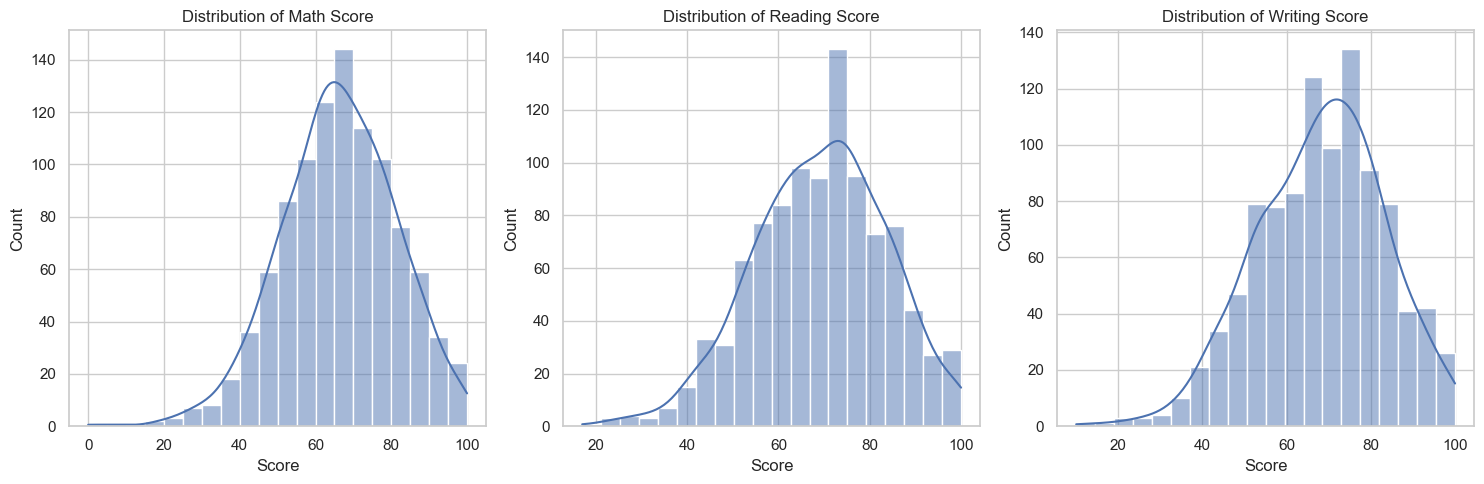

In [5]:
# 1. Distribution of scores
plt.figure(figsize=(15, 5))
for i, col in enumerate(['math_score', 'reading_score', 'writing_score'], 1):
    plt.subplot(1, 3, i)
    sns.histplot(data[col], bins=20, kde=True)
    plt.title(f'Distribution of {col.replace("_", " ").title()}')
    plt.xlabel('Score')
plt.tight_layout()
plt.savefig('outputs/score_distributions.png')
plt.show()

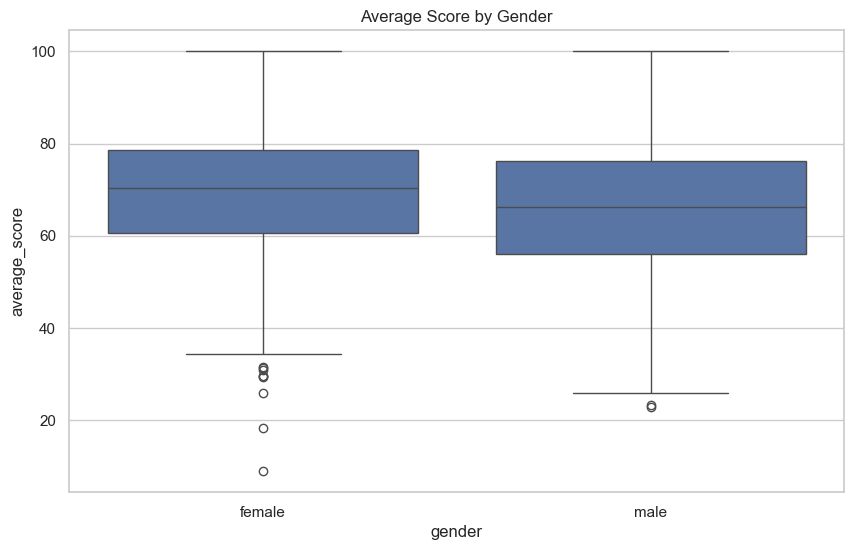

In [6]:
# 2. Average score by gender
plt.figure(figsize=(10, 6))
sns.boxplot(x='gender', y='average_score', data=data)
plt.title('Average Score by Gender')
plt.savefig('outputs/score_by_gender.png')
plt.show()

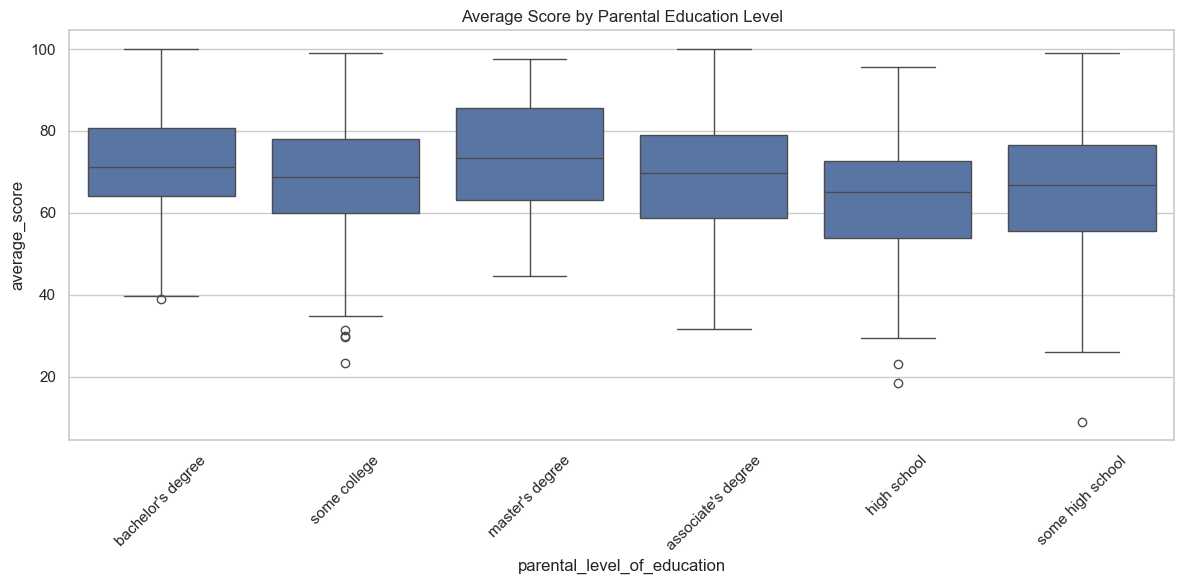

In [7]:
# 3. Average score by parental education
plt.figure(figsize=(12, 6))
sns.boxplot(x='parental_level_of_education', y='average_score', data=data)
plt.title('Average Score by Parental Education Level')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('outputs/score_by_parental_education.png')
plt.show()

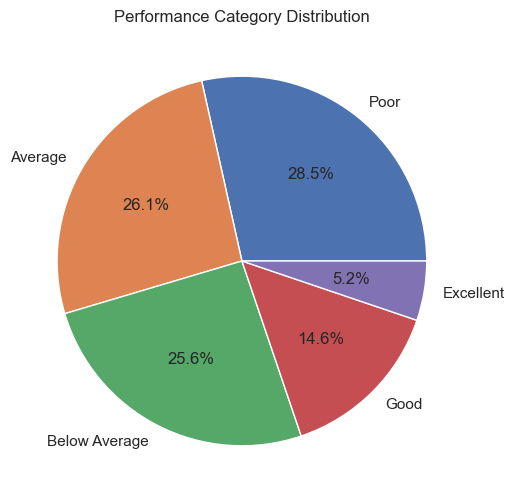

In [8]:
# 4. Performance category distribution
plt.figure(figsize=(10, 6))
performance_counts = data['performance_category'].value_counts()
plt.pie(performance_counts, labels=performance_counts.index, autopct='%1.1f%%')
plt.title('Performance Category Distribution')
plt.savefig('outputs/performance_category_distribution.png')
plt.show()

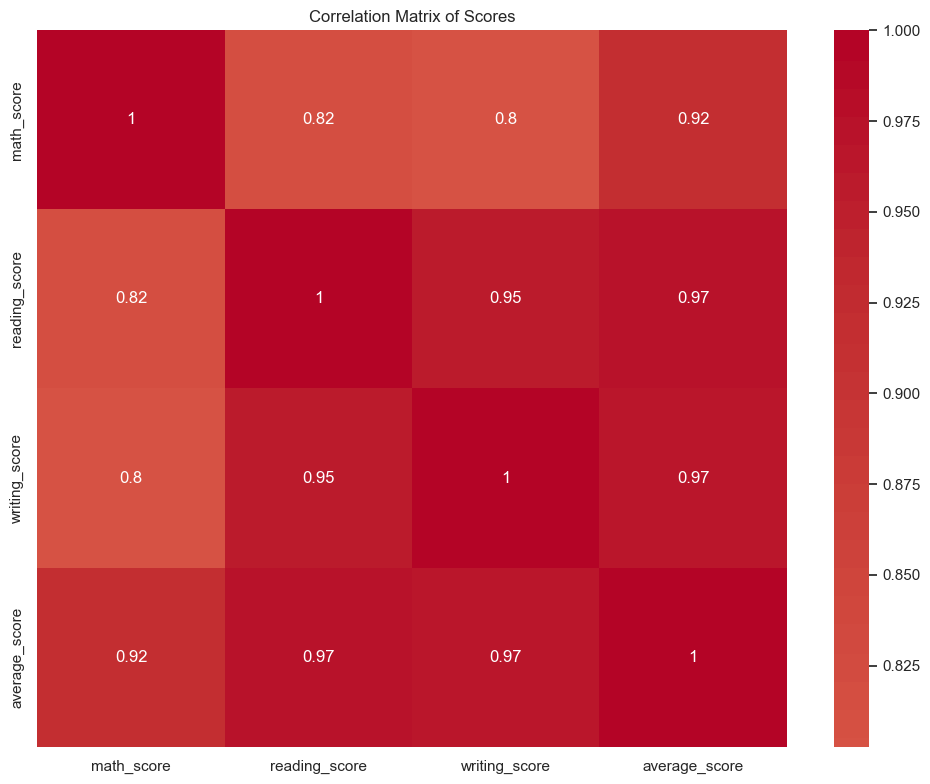

In [9]:
# 5. Correlation heatmap
plt.figure(figsize=(10, 8))
corr_matrix = data[['math_score', 'reading_score', 'writing_score', 'average_score']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Scores')
plt.tight_layout()
plt.savefig('outputs/correlation_matrix.png')
plt.show()

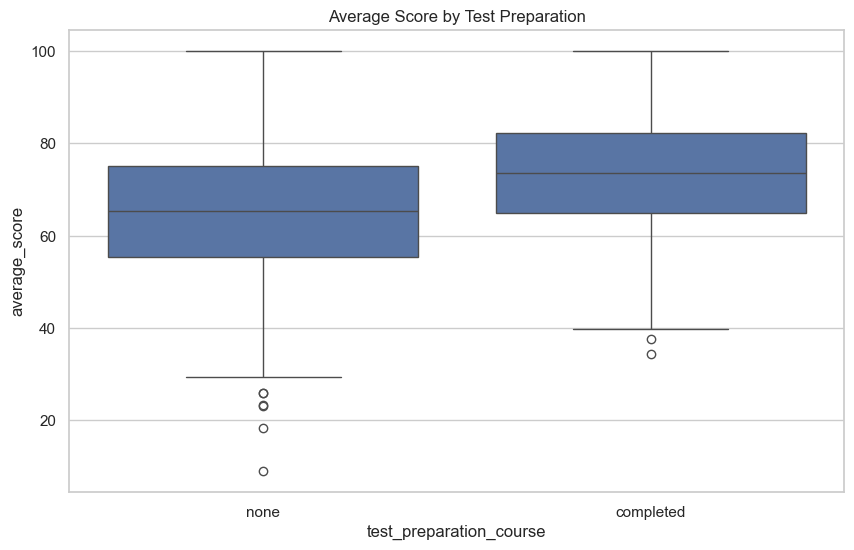

In [10]:
# 6. Score comparison by test preparation
plt.figure(figsize=(10, 6))
sns.boxplot(x='test_preparation_course', y='average_score', data=data)
plt.title('Average Score by Test Preparation')
plt.savefig('outputs/score_by_test_preparation.png')
plt.show()

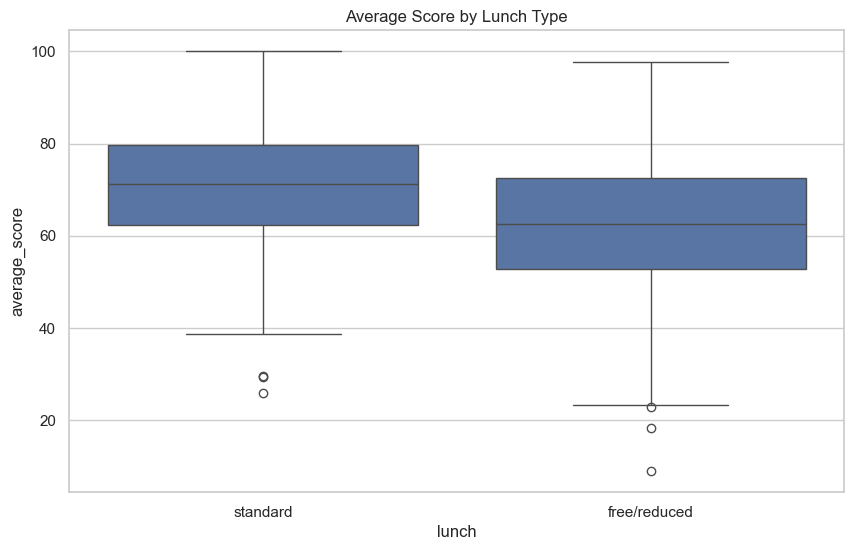

In [11]:
# 7. Score comparison by lunch type
plt.figure(figsize=(10, 6))
sns.boxplot(x='lunch', y='average_score', data=data)
plt.title('Average Score by Lunch Type')
plt.savefig('outputs/score_by_lunch.png')
plt.show()

## Final Summary

In [12]:
print("\n" + "="*50)
print("Cleaning and analysis summary")
print("=".center(50, "="))

print("DATA QUALITY SUMMARY:")
print(f"Initial shape: {data.shape}")
print(f"Duplicate rows removed: {duplicate_count}")
print(f"Final shape: {data.shape}")

print("\nFEATURES CREATED:")
print("- total_score: Sum of all three scores")
print("- average_score: Average of all three scores")
print("- performance_category: Categorical performance rating")

print("\nKey insights:")
# Calculate some basic insights
avg_math = data['math_score'].mean()
avg_reading = data['reading_score'].mean()
avg_writing = data['writing_score'].mean()

print(f"- Average Math Score: {avg_math:.2f}")
print(f"- Average Reading Score: {avg_reading:.2f}")
print(f"- Average Writing Score: {avg_writing:.2f}")
print(f"- Strongest correlation: between reading and writing scores ({corr_matrix.loc['reading_score', 'writing_score']:.3f})")

# Performance category distribution
performance_dist = data['performance_category'].value_counts(normalize=True) * 100
print("\nPerformance category distribution:")
for category, percentage in performance_dist.items():
    print(f"- {category}: {percentage:.1f}%")

# Save cleaned dataset
data.to_csv('data/cleaned_student_performance.csv', index=False)
print(f"\nCleaned dataset saved to: data/cleaned_student_performance.csv")

print("\n" + "="*50)
print("Data cleaning challenge completed!")
print("=".center(50, "="))


Cleaning and analysis summary
DATA QUALITY SUMMARY:
Initial shape: (1000, 11)
Duplicate rows removed: 0
Final shape: (1000, 11)

FEATURES CREATED:
- total_score: Sum of all three scores
- average_score: Average of all three scores
- performance_category: Categorical performance rating

Key insights:
- Average Math Score: 66.09
- Average Reading Score: 69.17
- Average Writing Score: 68.05
- Strongest correlation: between reading and writing scores (0.955)

Performance category distribution:
- Poor: 28.5%
- Average: 26.1%
- Below Average: 25.6%
- Good: 14.6%
- Excellent: 5.2%

Cleaned dataset saved to: data/cleaned_student_performance.csv

Data cleaning challenge completed!
